# Introduction to DDT analysis 

Let's just start this story by plotting a simple sine wave....


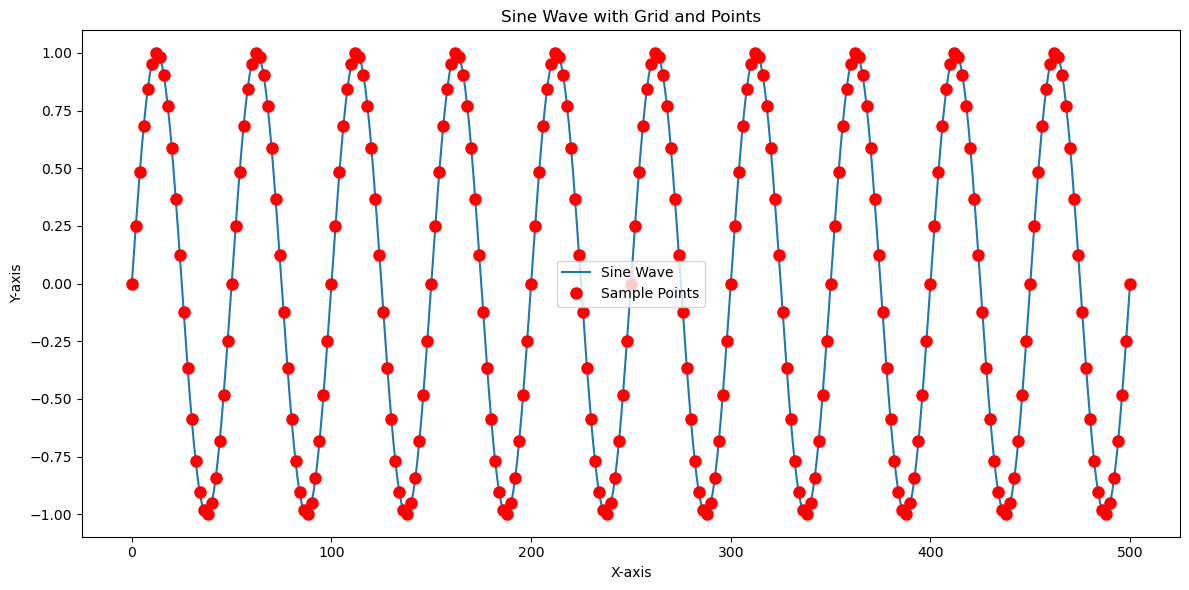

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define parameters
wavelength = 50
amplitude = 1
start = 0
end = 500 
samples_per_wavelength = 50  # Increase for smoother curve
ss=25 # sub samples per wavelength for red dots

pss=math.floor(samples_per_wavelength/ss)

# Generate x and y values
x = np.linspace(start, end, int((end - start) / wavelength * samples_per_wavelength)+1)
y = amplitude * np.sin(2 * np.pi * x / wavelength)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sine wave
ax.plot(x, y, label='Sine Wave')

# Add points to the curve
ax.plot(x[::pss], y[::pss], 'ro', markersize=8, label='Sample Points')  # Red circles, every 10th point

# Create grid lines at integer x values
#for i in x[::pss]:
#    ax.axvline(x=i, color='lightgray', linestyle=':')

# Customize plot appearance
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Sine Wave with Grid and Points')
ax.legend()

# Show the plot
plt.tight_layout() # Prevents labels from being cut off
plt.show()


### Discussion

1) If we have 10 waves and 25 samples per wave, how many red points are required to prepresent the series?

2) If we instead represent the data as a sinewave how many numbers are required to represent the data?


So we can represent the data either in physical space, or in Fourrier space, that is, as a sum of sine waves, each described by its amplitude and phase.

Okay, this was for a single sinewave.  But what about other more generalized series and forms.  Well it turns out that any function in time (or space) can be represented by a sum of sinewaves.  (When Fourier first introduced this idea it was apparently rejected by many of the leading mathematicians of the idea for quite some time!)

The function don't even need to be smooth (infinitely differentiable).  For example, it is possible to show that we can represent an ideal *square* wave with an amplitude of 1 as an infinite sum of sinusoidal waves:

$$f(t) = \frac{4}{\pi} \sum_{k=1}^{n} \frac{\sin((2k - 1)ft)}{2k - 1}$$

Where $f$ is the frequency in Hertz (cycles per second). The $2k-1$ term in the sine means only odd cycles are used, and the denominator factor is a scale factor. 

Let's try it out with a square wave of frequency of Hertz!

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def square_wave(t):
    """Generates a square wave."""
    return np.sign(np.sin(t))

def sum_of_sinusoids(t, num_terms):
    """Approximates a square wave using a sum of sinusoids."""
    approximation = np.zeros_like(t, dtype=float)
    for k in range(1, num_terms + 1):
        approximation += (4 / (np.pi * (2 * k - 1))) * np.sin((2 * k - 1) * t)
    return approximation

def plot_square_wave_approximation(time, square_signal, num_terms=1):
    """Plots the square wave and its sinusoidal approximation."""
    sinusoid_approximation = sum_of_sinusoids(time, num_terms)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8)) # creates subplot with one panel

    ax.plot(time, square_signal, label='Square Wave')
    ax.plot(time, sinusoid_approximation, label=f'{num_terms} Terms Approximation')

    ax.set_title('Square Wave and Sinusoid Approximation')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)
    plt.show()

### Exercise

With start with one term by default, but try increasing this and rerunning the following code...

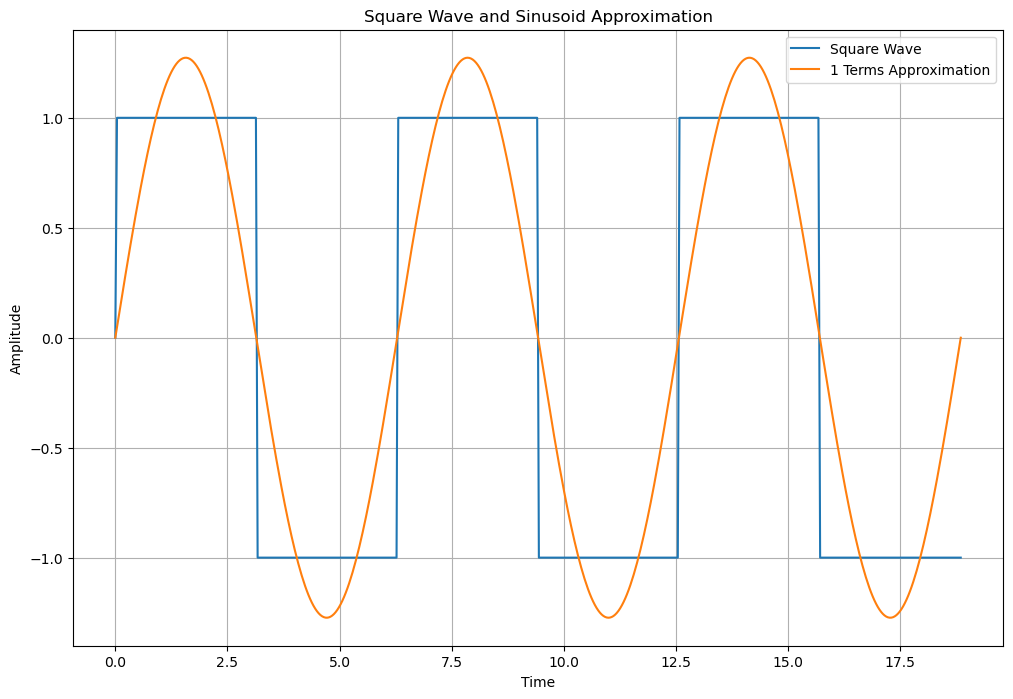

In [15]:
# Parameters
frequency = 1  # Frequency of the square wave
period = 2 * np.pi / frequency  # Period
time = np.linspace(0, 3 * period, 500)  # Time range for plotting

# Generate the square wave
square_signal = square_wave(time)

# Plot the square wave and its approximation
num_terms = 1  # Number of terms in the sinusoid approximation
plot_square_wave_approximation(time, square_signal, num_terms)

# Fourier Series

Let's imagine then any function at all that is periodic (later we will see this holds for non periodic signals).

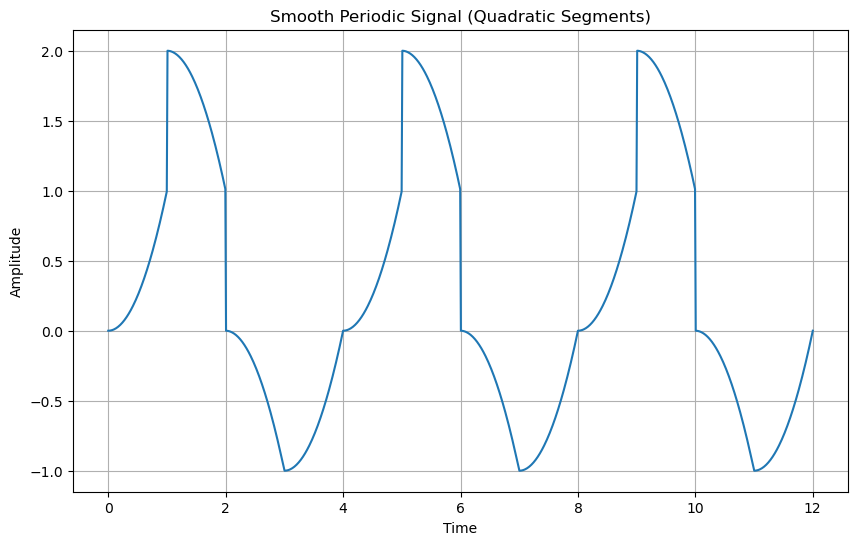

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def generate_smooth_periodic_signal_alt(t):
    """Generates a smooth periodic signal using different functions (no sin/cos, no noise)."""
    signal = np.zeros_like(t, dtype=float)
    for i, time_val in enumerate(t):
        phase = time_val % 4
        if 0 <= phase < 1:
            signal[i] = phase**2  # Quadratic rise
        elif 1 <= phase < 2:
            signal[i] = 2 - (phase - 1)**2  # Inverted quadratic peak
        elif 2 <= phase < 3:
            signal[i] = -(phase - 2)**2 # quadratic fall
        else:
            signal[i] = (phase-3)**2 - 1 # quadratic dip
    return signal

# Parameters
period = 4  # Period of the signal (for time range)
time = np.linspace(0, 12, 1000)  # Time range for plotting (3 periods)

# Generate the signal
smooth_periodic_signal = generate_smooth_periodic_signal_alt(time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, smooth_periodic_signal)
plt.title("Smooth Periodic Signal (Quadratic Segments)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Fourier determined that such a function can be represented as a series of sines and cosines. In other words he showed that a function such as the one above can be represented as a sum of sines and cosines of different frequencies, called a Fourier Series. There are two common forms of the Fourier Series, "Trigonometric" and "Exponential." These are discussed below, followed by a demonstration that the two forms are equivalent: 

Trigonometric Form (Sum of Sines and Cosines)
$$ x(t) = a_0 + \sum_{n=1}^{\infty} \left[ a_n \cos(n \omega t) + b_n \sin(n \omega t) \right] $$

Complex Exponential Form (Sum of Complex Numbers)
$$x(t) = \sum_{n=-\infty}^{\infty} c_n e^{j n \omega t} $$

## Discrete Fourier transform (DFT)

The DFT of a series of $n$ data points (where $n$ is typically assumed to be even for simplicity, though DFTs can be calculated for odd $n$) produces $n$ complex numbers. These complex numbers represent the frequency components of the signal.  Each complex number corresponds to a specific frequency. However, these frequency components aren't just sine waves. They represent both sine and cosine waves (or, equivalently, sine waves with phase shifts).

## Mathematical Introduction to FFT Analysis for Time Series

Let $x[n]$ represent a discrete-time signal, where $n$ is an integer index representing the time sample, and $n = 0, 1, ..., N-1$, with $N$ being the total number of samples. The Discrete Fourier Transform (DFT) of $x[n]$, denoted as $X[k]$, is defined as:

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j 2\pi kn/N}$$

where $k = 0, 1, ..., N-1$ represents the frequency index, and $j$ is the imaginary unit ($j^2 = -1$). The $e^{-j 2\pi kn/N}$ term represents a complex sinusoid at frequency $k/N$.

The DFT decomposes the signal $x[n]$ into a sum of complex sinusoids, each with a specific frequency and amplitude. The output $X[k]$ is a complex-valued sequence, where the magnitude $|X[k]|$ represents the amplitude of the frequency component $k/N$, and the phase $\arg(X[k])$ represents the phase shift of that component.

The inverse DFT (IDFT) reconstructs the original signal $x[n]$ from its DFT coefficients $X[k]$:

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j 2\pi kn/N}$$

The Fast Fourier Transform (FFT) is an efficient algorithm to compute the DFT and IDFT. It leverages the symmetry and periodicity properties of the complex exponential term to reduce the computational complexity from $O(N^2)$ for the direct DFT calculation to $O(N \log N)$.

For a real-valued input signal $x[n]$, the DFT output $X[k]$ exhibits conjugate symmetry, i.e., $X[k] = X^*[N-k]$, where $*$ denotes complex conjugation. This means that the negative frequency components ($k > N/2$) are redundant, and we typically focus on the positive frequency components ($k \le N/2$).

The frequency resolution $\Delta f$ of the DFT is given by:

$$\Delta f = \frac{f_s}{N}$$

where $f_s$ is the sampling frequency (the number of samples per unit time). The maximum frequency that can be represented without aliasing is the Nyquist frequency, which is half the sampling frequency:

$$f_{Nyquist} = \frac{f_s}{2}$$

The frequency corresponding to the $k$-th DFT coefficient is:

$$f_k = k \Delta f = \frac{k f_s}{N}$$

The amplitude spectrum of the signal is obtained by computing the magnitude $|X[k]|$ of the DFT coefficients. The power spectrum is given by $|X[k]|^2$.

Windowing functions, such as Hamming or Hanning windows, are often applied to the input signal $x[n]$ before computing the DFT to reduce spectral leakage, which occurs when the signal is not periodic within the observation window.


In [77]:
#%pip install cftime

In [78]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import urllib.request
import cftime
import datetime

In [45]:
def calculate_significant_peaks(amplitudes, confidence_level=0.95):
    """
    Calculates which peaks in an FFT amplitude spectrum are statistically significant.

    Args:
        amplitudes (np.ndarray): The FFT amplitudes.
        confidence_level (float): The desired confidence level (e.g., 0.95 for 95%).

    Returns:
        np.ndarray: A boolean array indicating which peaks are significant.
    """

    # Calculate the noise level (mean of amplitudes)
    noise_level = np.mean(amplitudes)

    # Calculate the standard deviation of the amplitudes
    std_dev = np.std(amplitudes)

    # Calculate the significance threshold using a t-distribution
    # Degrees of freedom (df) is the number of independent samples (length of amplitudes - 1)
    df = len(amplitudes) - 1

    # Calculate the t-critical value using scipy's t-distribution
    t_critical = stats.t.ppf(confidence_level, df)

    # Calculate the significance threshold
    significance_threshold = noise_level + t_critical * (std_dev / np.sqrt(len(amplitudes)))

    # Determine which peaks are significant
    significant_peaks = amplitudes > significance_threshold

    return significant_peaks

We will also introduce a separate polotting routine in order to keep things clean


In [ ]:

def plot_fft_spectrum(frequencies, periods, amplitudes):
    """
    Plots the frequency spectrum.

    Args:
        frequencies (np.ndarray): Frequencies (cycles/day).
        periods (np.ndarray): Periods (days).
        amplitudes (np.ndarray): Amplitudes.
    """

    positive_freq_indices = frequencies > 0

    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axes

    ax.plot(periods[positive_freq_indices], amplitudes[positive_freq_indices])
    ax.set_xlabel("Period (days)")
    ax.set_ylabel("Amplitude (log scale)")
    ax.set_title("Frequency Spectrum")
    ax.grid(True)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(365 * 10,0.1)

    return fig,ax

decode
seconds since 1970-01-01  units
sec detected


Text(1, 1, 'day')

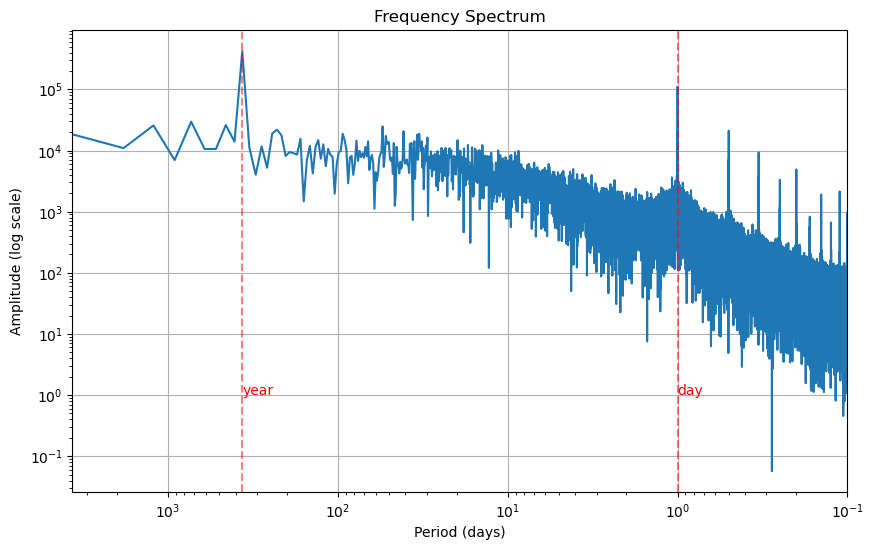

In [49]:

# Download example data
# url = "https://downloads.psl.noaa.gov/Datasets/era5/hourly/air.2m.2023.nc"
# filename = "air.2m.2023.nc"
# urllib.request.urlretrieve(url, filename)

datadir="/Users/tompkins/DATA/era5/hourly/"
filename=datadir+"t2m_t.nc"

# Open the NetCDF file
decode_times=False
ds = xr.open_dataset(filename, decode_times=decode_times)
if not decode_times:
    print ("decode")
    time_units = ds["valid_time"].units
    time_values = ds["valid_time"].values

    # Extract the base date from the time units
    base_date_str = time_units.split('since ')[1]

    # Convert seconds to datetime objects
    times = cftime.num2date(time_values, units = time_units, calendar = 'standard')

    # Replace the time coordinate
    # ds['time'] = datetimes

# Select a specific location and time range
lat = 45.6
lon = 13.7
t2m = ds["t2m"].sel(latitude=lat, longitude=lon,method='nearest')
# time = ds['time']

# Perform FFT analysis
frequencies, periods, amplitudes = analyze_time_series_fft(t2m, time_values, time_units)
fig,ax=plot_fft_spectrum(frequencies, periods, amplitudes)

ax.axvline(x=365, color='red', linestyle='--',alpha=0.5)
ax.text(365,1,"year",color='red')
ax.axvline(x=1, color='red', linestyle='--',alpha=0.5)
ax.text(1,1,"day",color='red')


In [13]:
def calculate_significant_peaks(amplitudes, confidence_level=0.95):
    """
    Calculates which peaks in an FFT amplitude spectrum are statistically significant.

    Args:
        amplitudes (np.ndarray): The FFT amplitudes.
        confidence_level (float): The desired confidence level (e.g., 0.95 for 95%).

    Returns:
        np.ndarray: A boolean array indicating which peaks are significant.
    """

    # Calculate the noise level (mean of amplitudes)
    noise_level = np.mean(amplitudes)

    # Calculate the standard deviation of the amplitudes
    std_dev = np.std(amplitudes)

    # Calculate the significance threshold using a t-distribution
    # Degrees of freedom (df) is the number of independent samples (length of amplitudes - 1)
    df = len(amplitudes) - 1

    # Calculate the t-critical value using scipy's t-distribution
    t_critical = stats.t.ppf(confidence_level, df)

    # Calculate the significance threshold
    significance_threshold = noise_level + t_critical * (std_dev / np.sqrt(len(amplitudes)))

    # Determine which peaks are significant
    significant_peaks = amplitudes > significance_threshold

    return significant_peaks